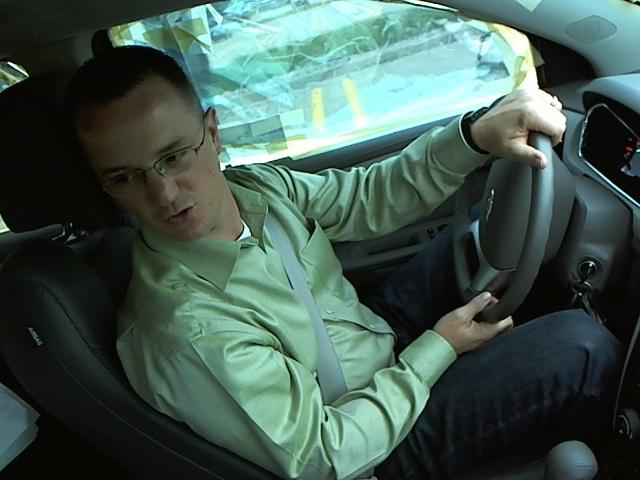

In [1]:
# Testing Photo 
from PIL import Image
import s3fs

fs = s3fs.S3FileSystem()

with fs.open(f's3://sagemaker-team6-distracted-drivers/Imgs/train/c9/img_100090.jpg') as f:
    display(Image.open(f))

In [2]:
# Checking How many images in train

!aws s3 ls s3://sagemaker-team6-distracted-drivers/Imgs/train/ --recursive --summarize | grep "Total Objects:"

Total Objects: 22424


In [3]:
# Checking how many images in test

!aws s3 ls s3://sagemaker-team6-distracted-drivers/Imgs/test/ --recursive --summarize | grep "Total Objects:"

Total Objects: 15181


In [4]:
# Image size in s3 bucket

with fs.open(f's3://sagemaker-team6-distracted-drivers/Imgs/train/c9/img_100090.jpg') as f:
    image = Image.open(f)
    width, height = image.size
    print(f"Image width: {width}, height: {height}")

Image width: 640, height: 480


In [5]:
# Testing image rezie using basic python, saving images in scrap folder to not alter s3 size

import boto3
from PIL import Image
from io import BytesIO
import time
import os

# Creating scrap folder for photos
scrap_folder = "/home/sagemaker-user/Big-Data-Systems/Team 6/scrap_photo"
os.makedirs(scrap_folder, exist_ok=True)

s3_client = boto3.client('s3')

bucket = 'sagemaker-team6-distracted-drivers'
path = 'Imgs/train/c0'

save_dir = '/home/sagemaker-user/Big-Data-Systems/Team 6/scrap_photo'

s3_objects = s3_client.list_objects_v2(Bucket=bucket, Prefix=path)

start_time = time.time()

for obj in s3_objects.get('Contents', []):
    key = obj['Key']
    if key.endswith('.jpg'):
        response = s3_client.get_object(Bucket=bucket, Key=key)
        image_content = response['Body'].read()
        image = Image.open(BytesIO(image_content))

        rezised_image = image.resize((120, 120))
    
        save_path = os.path.join(save_dir, f"resized_{os.path.basename(key)}")
        rezised_image.save(save_path)

end_time = time.time()

base_resize_time = end_time - start_time

base_resize_time

/home/sagemaker-user/.conda/envs/data_science_on_aws/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


53.00742506980896

In [6]:
#Seeing if s3 bucket size was changed

with fs.open(f's3://sagemaker-team6-distracted-drivers/Imgs/train/c0/img_102087.jpg') as f:
    image = Image.open(f)
    width, height = image.size
    print(f"Image width: {width}, height: {height}")

Image width: 640, height: 480


In [7]:
# Checking if scrap photo size was changed
test_image_path = 'resized_img_102087.jpg'

image_path = os.path.join(save_dir, test_image_path)

with Image.open(image_path) as img:
    width, height = img.size
    print(f"Image width: {width}, height: {height}")


Image width: 120, height: 120


In [8]:
# Delete new folder
import shutil
shutil.rmtree(scrap_folder)

In [9]:
!pip install pyspark

In [10]:
# Using Apache Spark

from pyspark.sql import SparkSession
from pyspark import SparkFiles

spark = SparkSession.builder.appName("ImageResize").getOrCreate()


# Creating scrap folder for photos
scrap_folder = "/home/sagemaker-user/Big-Data-Systems/Team 6/scrap_photo"
os.makedirs(scrap_folder, exist_ok=True)

s3_client = boto3.client('s3')

bucket = 'sagemaker-team6-distracted-drivers'
path = 'Imgs/train/c0'

save_dir = '/home/sagemaker-user/Big-Data-Systems/Team 6/scrap_photo'

s3_objects = s3_client.list_objects_v2(Bucket=bucket, Prefix=path)

def rezise_image(image_content):
    image = Image.open(BytesIO(image_content))
    resized_image = image.resize((120,120))
    return resized_image


def process_partition(iterator):
    for obj in iterator:
        key = obj['Key']
        image_content = s3_client.get_object(Bucket=bucket, Key=key)['Body'].read()

        rezied_image = rezised_image(image_content)

        save_path = os.path.join(save_dir, f"resized_{os.path.basename(key)}")

        rezised_image.save(save_path)

start_time = time.time()

rdd = spark.sparkContext.parallelize(s3_objects.get('Contents', []), numSlices=4) 
rdd.mapPartitions(process_partition).foreach(lambda _: None)

end_time = time.time()

spark_total_time = end_time - start_time

spark.stop()

spark_total_time

JAVA_HOME is not set


RuntimeError: Java gateway process exited before sending its port number

In [11]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [12]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>